In [1]:
%cd ..
%cd ..

/home/ltorres/leo/tesis/cloud-classification/code/notebooks
/home/ltorres/leo/tesis/cloud-classification/code


In [2]:
%load_ext autoreload
%autoreload 2

---

In [3]:
from torchvision.io import read_image
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from random import sample
import torch
import torch.nn as nn
from torch.optim import lr_scheduler

In [4]:
from src.dataset import GCD
from src import config
from src import engine_gnn as engine
from src import utils

from src.models.graph_nets import GraphConvGNN, GATConvGNN

from notebooks.adjacency_construction.adjacency_models import *

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
import wandb

#### PARAMS

In [7]:
device = config.DEVICE


BUILDER = 'pearson_corr'
builder_name = "Pearson correlation"
LR = 3e-4
EPOCHS = 15


exp_name = '2_PEARSON_CORR_06_04_22'
model_filename = f'/adjacency_builders/{exp_name}.pt'

---

In [8]:
wandb.login()

wandb: Currently logged in as: leonardtd (use `wandb login --relogin` to force relogin)


True

#### Data loaders

In [9]:
path_train_images = utils.get_gcd_paths(config.DATA_DIR,'train')

In [10]:
train_dataset = GCD(path_train_images, resize=256)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

In [11]:
path_test_images = utils.get_gcd_paths(config.DATA_DIR,'test')

test_dataset = GCD(path_test_images, resize=256)

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=False,
    )

### Data augmentation data loaders

In [12]:
aug_dataset = GCD(path_train_images, resize=256, aug_types='augmentation')

augmentation_loader = torch.utils.data.DataLoader(
        aug_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=4,
        shuffle=True,
    )

#### Model

In [13]:
from torchvision import models

In [14]:
torch.cuda.empty_cache()

In [15]:
model = GATConvGNN(7, 1024, 2, 4, 0.5, adjacency_builder = BUILDER).to(device)

In [16]:
criterion = utils.loge_loss
optimizer  = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

####  wandb

In [17]:
wandb.init(
    # Set the project where this run will be logged
    project="cloud classification - adjacency",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=exp_name, 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": LR,
    "architecture": "GATConvGNN",
    "loss": "LogeLoss",
    "optim": "SGD",
    "dataset": "GCD",
    "builder": f"{builder_name}",
    "epochs": EPOCHS,
  })

### Train

In [18]:
best_accuracy=0
best_iteration=0
best_params={}

for e in range(EPOCHS):
    ### TRAIN DATASET
    preds, targets, loss = engine.train_fn(model, train_loader, criterion, optimizer, device=device)
    train_acc = accuracy_score(targets, preds)
    
    ### AUGMENTATION IMAGES
    engine.forward_backward_pass(model, augmentation_loader, criterion, optimizer, device=device)
    
    scheduler.step()
    
    test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)
    test_acc = accuracy_score(test_targets, test_preds)
    
    if test_acc > best_accuracy:
        torch.save(model.state_dict(), config.SAVE_PATH+model_filename)
        print(f"Saved best parameters at epoch {e+1}")
        best_accuracy = test_acc
        best_iteration = e+1
        best_params = model.state_dict()
    
    print("EPOCH {}: Train acc: {:.2%} Train Loss: {:.4f} Test acc: {:.2%} Test Loss: {:.4f}".format(
        e+1,
        train_acc,
        loss,
        test_acc,
        test_loss
    ))
    
    metrics = {
                "train/train_loss": loss,
                "train/train_accuracy": train_acc,
                "test/test_loss": test_loss,
                "test/test_accuracy": test_acc,
              }

    wandb.log(metrics)


100%|██████████| 282/282 [00:17<00:00, 16.01it/s]


Saved best parameters at epoch 1
EPOCH 1: Train acc: 68.94% Train Loss: 1.9465 Test acc: 73.53% Test Loss: 1.5216


100%|██████████| 282/282 [00:17<00:00, 15.80it/s]


Saved best parameters at epoch 2
EPOCH 2: Train acc: 86.09% Train Loss: 0.8225 Test acc: 75.67% Test Loss: 1.4421


100%|██████████| 282/282 [00:17<00:00, 15.88it/s]


Saved best parameters at epoch 3
EPOCH 3: Train acc: 88.78% Train Loss: 0.6807 Test acc: 77.19% Test Loss: 1.4523


100%|██████████| 282/282 [00:17<00:00, 15.89it/s]


Saved best parameters at epoch 4
EPOCH 4: Train acc: 90.47% Train Loss: 0.5691 Test acc: 78.04% Test Loss: 1.4023


100%|██████████| 282/282 [00:17<00:00, 15.90it/s]


Saved best parameters at epoch 5
EPOCH 5: Train acc: 91.79% Train Loss: 0.4873 Test acc: 78.06% Test Loss: 1.3879


100%|██████████| 282/282 [00:17<00:00, 15.94it/s]


EPOCH 6: Train acc: 93.15% Train Loss: 0.4223 Test acc: 77.82% Test Loss: 1.4050


100%|██████████| 282/282 [00:17<00:00, 15.82it/s]


EPOCH 7: Train acc: 94.07% Train Loss: 0.3652 Test acc: 77.07% Test Loss: 1.4791


100%|██████████| 282/282 [00:17<00:00, 15.82it/s]


EPOCH 8: Train acc: 94.87% Train Loss: 0.3248 Test acc: 77.93% Test Loss: 1.4000


100%|██████████| 282/282 [00:17<00:00, 15.91it/s]


Saved best parameters at epoch 9
EPOCH 9: Train acc: 95.89% Train Loss: 0.2634 Test acc: 78.10% Test Loss: 1.4103


100%|██████████| 282/282 [00:17<00:00, 15.96it/s]


EPOCH 10: Train acc: 96.48% Train Loss: 0.2260 Test acc: 75.87% Test Loss: 1.5331


100%|██████████| 282/282 [00:17<00:00, 16.00it/s]


EPOCH 11: Train acc: 97.26% Train Loss: 0.1780 Test acc: 77.49% Test Loss: 1.4384


100%|██████████| 282/282 [00:17<00:00, 15.88it/s]


EPOCH 12: Train acc: 98.02% Train Loss: 0.1341 Test acc: 77.71% Test Loss: 1.4216


100%|██████████| 282/282 [00:17<00:00, 15.90it/s]


EPOCH 13: Train acc: 98.25% Train Loss: 0.1207 Test acc: 77.22% Test Loss: 1.4596


100%|██████████| 282/282 [00:17<00:00, 15.90it/s]


EPOCH 14: Train acc: 98.42% Train Loss: 0.1085 Test acc: 77.92% Test Loss: 1.4188


100%|██████████| 282/282 [00:17<00:00, 15.90it/s]

EPOCH 15: Train acc: 98.29% Train Loss: 0.1157 Test acc: 77.64% Test Loss: 1.4390


In [19]:
wandb.finish()

test/test_accuracy,▁▄▇███▆██▅▇▇▇█▇
test/test_loss,▇▄▄▂▁▂▅▂▂█▃▃▄▂▃
train/train_accuracy,▁▅▆▆▆▇▇▇▇██████
train/train_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
test/test_accuracy,0.77644
test/test_loss,1.43904
train/train_accuracy,0.9829
train/train_loss,0.11567


In [20]:
model.load_state_dict(torch.load(config.SAVE_PATH+model_filename))

<All keys matched successfully>

In [21]:
test_preds, test_targets, test_loss = engine.eval_fn(model, test_loader, criterion, device=device)

100%|██████████| 282/282 [00:17<00:00, 15.90it/s]


In [22]:
accuracy_score(test_targets, test_preds)

0.781

---

### Accuracy per class and confusion matrix

In [23]:
class_mapper = {
    0: '1_cumulus',
    1: '2_altocumulus',
    2: '3_cirrus',
    3: '4_clearsky',
    4: '5_stratocumulus',
    5: '6_cumulonimbus',
    6: '7_mixed',
}

In [24]:
class_acc = dict()
matrix = np.zeros((7,7), dtype=int)

for i in range(7):
    pred_index = np.where(test_targets==i)[0]
    class_acc[class_mapper[i]] = accuracy_score(test_targets[pred_index], test_preds[pred_index])
    
    for j in test_preds[pred_index]:
        matrix[i,j]+=1 

In [25]:
class_acc

{'1_cumulus': 0.6613333333333333,
 '2_altocumulus': 0.5106666666666667,
 '3_cirrus': 0.9136786188579017,
 '4_clearsky': 0.9886721208307111,
 '5_stratocumulus': 0.6513966480446928,
 '6_cumulonimbus': 0.8634552698297718,
 '7_mixed': 0.5617792421746294}

Global Test accuracy 0.781


<AxesSubplot:title={'center':'Confusion Matrix (Accuracy %)'}>

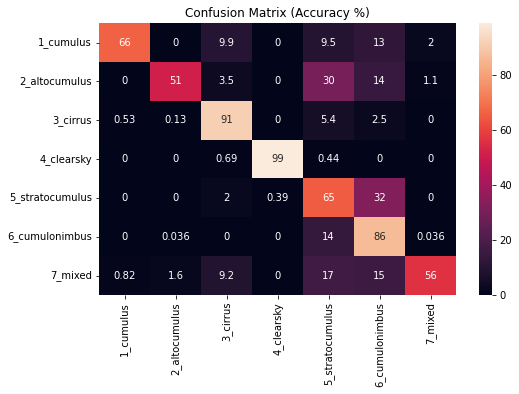

In [26]:
print(f"Global Test accuracy {accuracy_score(test_targets, test_preds)}")

sum_of_rows = matrix.sum(axis=1)
conf_mat = 100*matrix / sum_of_rows[:, np.newaxis]

df_cm = pd.DataFrame(conf_mat, index = class_acc.keys(),
                  columns = class_acc.keys())

plt.figure(figsize = (8,5))
plt.title("Confusion Matrix (Accuracy %)")
sns.heatmap(df_cm, annot=True)